## First Part: MDP and optimal control
### El Hassane Nour

##### 1. Assume that V is constant in time and equal to $V_{max}$, and that moving left or right costs 'a' unit of energy. Model the problem as a MDP, and explain how to compute the optimal solution for a given discount factor $\gamma$.

1.1. We define the three key elements of a MDP:
- **State Space S**: represent the possible values of $\theta$, which is the difference of angle between the wind orientation $\theta_{wind}$ and the turbine orientation $\theta_{turbine}$.
$\begin{equation}
\theta=\theta_{wind} - \theta_{turbine}
\end{equation}$
where: $\theta_{wind}, \theta_{turbine} \in [0,180]$

    So, we define S as: 

$\begin{equation}
S=\{-180, 179, ..., 0, 1, ... ,179, 180\}
\end{equation}$

- **Action Space A**: represent the possibles actions the wind turbine could do. That is, turn one degree left - means that $\theta_{turbine}$ moves by minus one degree (action 0) , stay still (action 1), or turn one degree right - means that $\theta_{turbine}$ moves by plus one degree (action 2).

    So, A is defined as: 

$\begin{equation}
A=\{0,1, 2\}
\end{equation}$

- **Reward Space R**: represent the reward of taking an action $a_t$ from a given state $s_t$, leading to a new state $s_{t+1}$. The reward would be equal to the energy produced during one time step which is: 

$\begin{equation}
\begin{split}
r(s_t,a_t) &= f(V)cos(\theta_t)-\alpha a \\
&= cos(\theta_t)-\alpha a \\
\text{where: }\alpha = \begin{cases}
1 & \text{if action is 0 or 2}\\
0 & \text{if action is 1}
\end{cases} 
\end{split}
\end{equation}$

- **Transitions Probability P**: represent the Markovian transitions from a state $s_t$ by performing an action $a_t$, to a state $s_{t+1}$ with receipt of a reward $r_t$. Three actions are possible from a given state, so we assign a uniform probability distributions over these actions. That is:
    $  P(S_{t+1} = \theta+1 | s_t = \theta,a_t = 0)=1/3\\
    P(S_{t+1} = \theta+1 | s_t = \theta,a_t = 1)=0\\
    P(S_{t+1} = \theta+1 | s_t = \theta,a_t = 2)=0\\
    P(S_{t+1} = \theta | s_t = \theta,a_t = 0)=0\\
    P(S_{t+1} = \theta | s_t = \theta,a_t = 1)=1/3\\
    P(S_{t+1} = \theta | s_t = \theta,a_t = 2)=0\\
    P(S_{t+1} = \theta-1 | s_t = \theta,a_t = 0)=0\\
    P(S_{t+1} = \theta-1 | s_t = \theta,a_t = 1)=0\\
    P(S_{t+1} = \theta-1 | s_t = \theta,a_t = 2)=1/3\\$

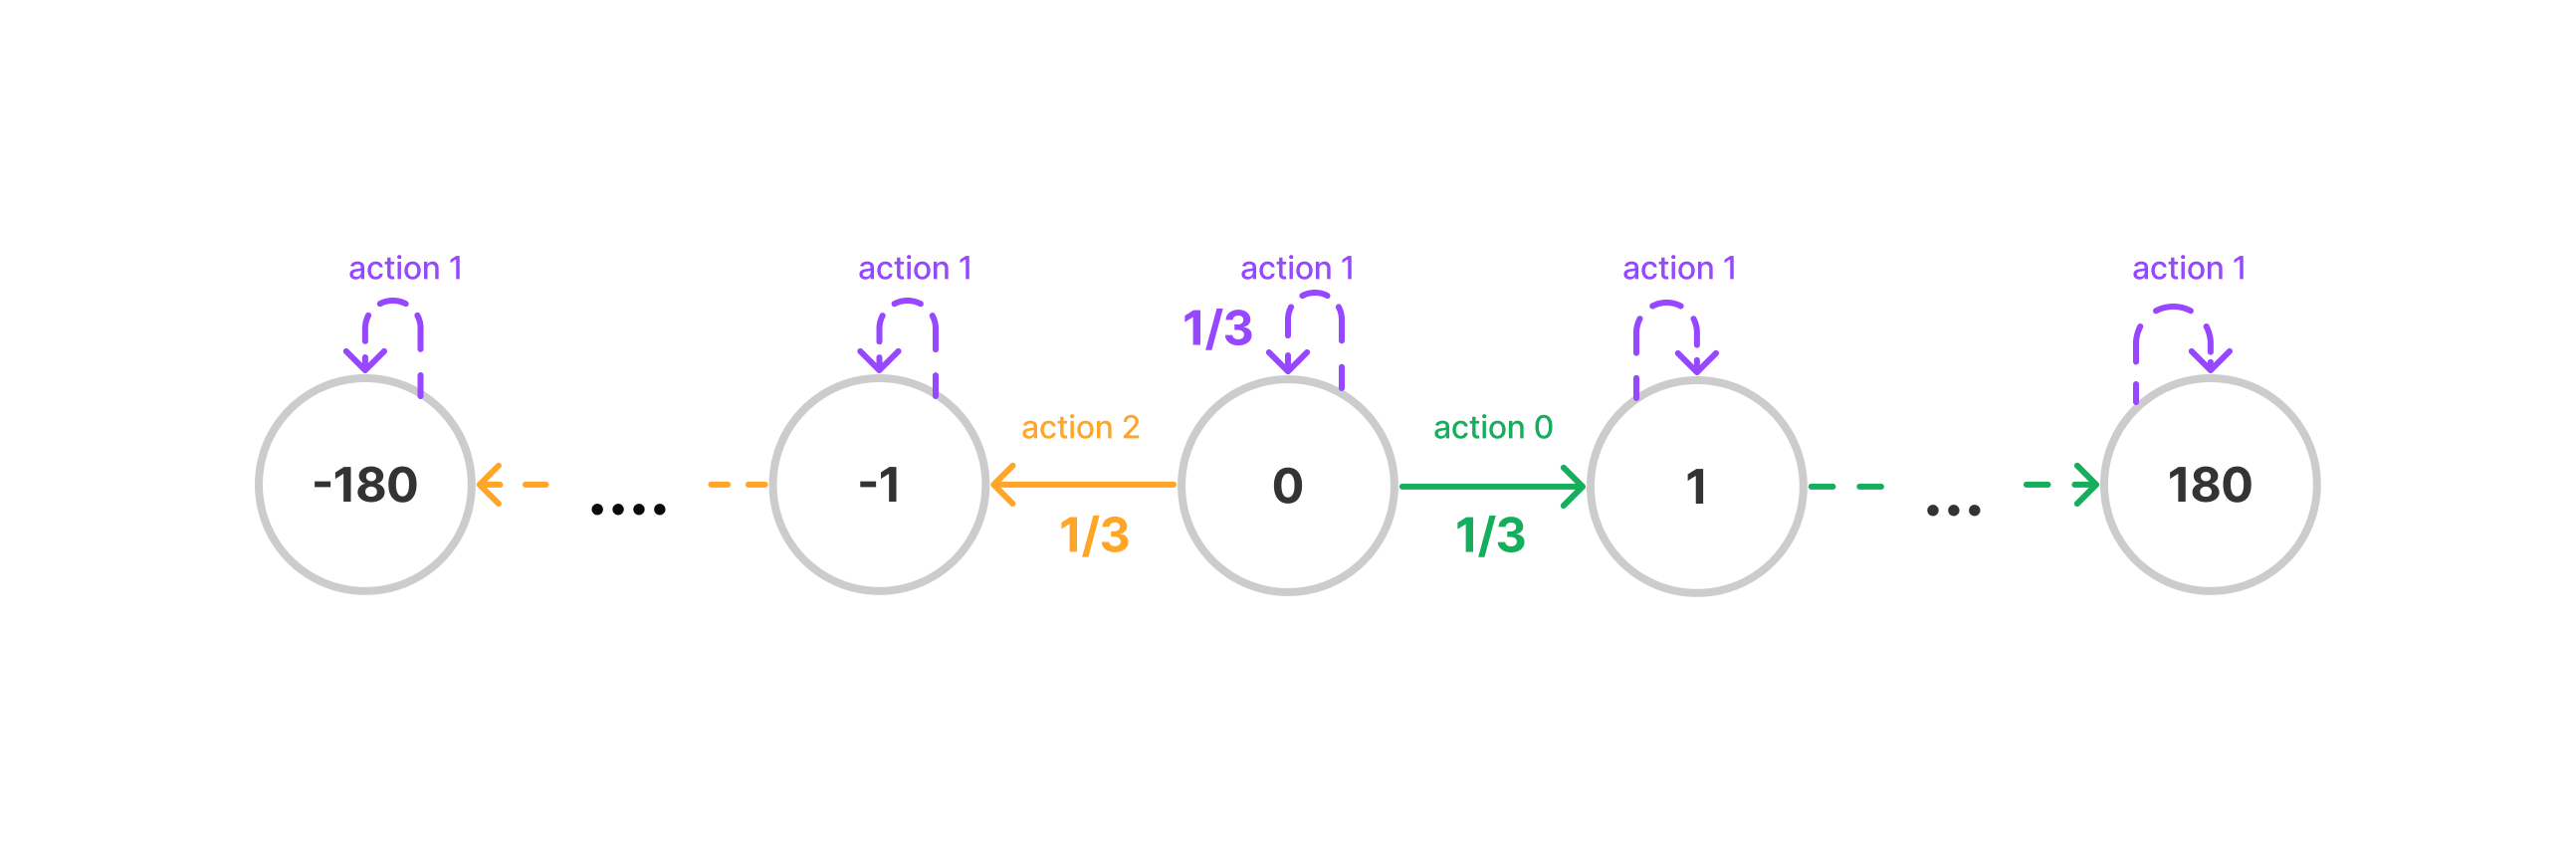

In [1]:
from IPython import display
display.Image("./mdp.png")

1.2. Optimal solution computation for a given discount factor $\gamma$

The optimal solution is defined by the best policy to follow in order to get the maximum value of power production. This could be found using the following value iteration algorithm:

Algorithm: Value Iteration

1 $\epsilon$: a small number

2 Initialize V(s) arbitrarily

/* Loop until convergence

3 $\delta \gets 1$

4 While $\delta > \epsilon$

5    for s $\in$ S do

6        v $\gets$ V(s)

7       V(s) $\gets \max_a \sum_{s',r'}p(s',r'|s,a)[r+\gamma V(s')]$

8        $\delta \gets \min(\delta, |v-V(s)|)$

9 return $\pi$ s.t. $\pi(s)=argmax_a V(s)$

##### 2. Implement an algorithm that finds the optimal solution and illustrate the optimal solution. You are free to choose your values of a and γ, but try to find ones that provide interesting results (Hint: Choose a close to 0 and γ close to 1).

In [59]:
import numpy as np

In [185]:
STATE_SPACE = list(range(-180,181)) # theta, which is the relative wind heading (wind heading - wind turbine heading)
ACTION_SPACE = [0,1,2]
NB_ACTIONS=len(ACTION_SPACE)
a=0.3
disc_fact=0.98
V_max=1

In [158]:
def f(velocity):
    return velocity**3 if velocity<=V_max else 0

In [191]:
# calculate the rewards for all state,action pairs
def rewards(v):
  reward = {} # key (s,a)
  for s in STATE_SPACE:
    for action in ACTION_SPACE:
      if action in [0,2]:
        reward[(s,action)]=f(v)*np.cos(s*np.pi/180)-a
      else:
        reward[(s,action)]=f(v)*np.cos(s*np.pi/180)
  return reward

In [247]:
# caluculate Markovian transitions from a state to another 
def trans_probs():
    probs = {}
    for s in STATE_SPACE :
        for a in ACTION_SPACE:
            probs[(s,a)] = [ 0 for i in range(len(STATE_SPACE))]
            if a == 0: #turn left == wind turbine heading minus one
                probs[(s,a)][STATE_SPACE.index((s+1)%180)] = 1/3
            if a == 1: #stay still
                probs[(s,a)][STATE_SPACE.index(s)] = 1/3
            if a == 2: #turn right == wind turbine heading plus one
                probs[(s,a)][STATE_SPACE.index((s-1)%180)] = 1/3
    return probs 

In [249]:
# finds the optimal policy that gives the optimal solution V*
class OptimalPolicy:
    def __init__(self,rewards,probs,gamma=0.8):
        self.rewards = rewards
        self.probs = probs
        self.gamma=gamma
        self.policy= [1 for i in range(len(STATE_SPACE))] # initialize pi(s) 
  
    def optimal_sol(self,nb_iter):
        V = [0 for i in range(len(STATE_SPACE))] # initialize V(s)     
        V_new = [0 for i in range(len(STATE_SPACE))]   # copy of V(s)
        epsilon=1e-400
        for i in range(nb_iter):
            delta = 0  # initialize max difference
            index=0
            for s in STATE_SPACE: # compute state value
                max_value = 0
                for a in ACTION_SPACE:
                    val = self.rewards[(s,a)]  # get the reward
                    if a==0:
                        S_next=STATE_SPACE.index((s+1)%180)
                        val += self.gamma*self.probs[(s,a)][S_next]*V[S_next]# add discounted downstream values
                    elif a==1:
                        val += self.gamma*self.probs[(s,a)][s]*V[index]# add discounted downstream values
                    elif a==2:
                        S_next=STATE_SPACE.index((s-1)%180)
                        val += self.gamma*self.probs[(s,a)][S_next]*V[S_next]# add discounted downstream values
                        
                    # store best value
                    max_value = max(max_value, val)

                    # Update best policy
                    if V[index] < val:
                        self.policy[index]=a  # store action with highest value

                V_new[index]=max_value  # update value with highest value
                # update maximum difference
                delta = max(delta, abs(V[index] - V_new[index]))
                index+=1

            # Update value functions
            V = V_new

            # If diff smaller than threshold delta for all states, algorithm terminates
            if delta < epsilon:
                break
        return V

In [ ]:
rwds=rewards(v=V_max)
probs=trans_probs()
policy=OptimalPolicy(rwds,probs)

In [251]:
nbs_iters = list(range(10,50,10))
differences = []
v_tmp = 0

for i in nbs_iters:
  v = policy.optimal_sol(i)
  diff = np.linalg.norm(np.asarray(v)-np.asarray(v_tmp))
  v_tmp = v.copy()
  differences.append(diff)


In order to check the convergence of the value iteration algorithm, we plot the distances between the value-state arrays of all iterations.

Text(0.5, 1.0, 'State-value convergence')

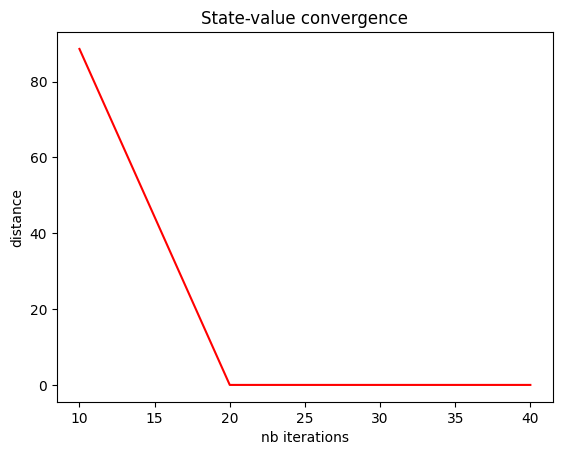

In [252]:
import matplotlib.pyplot as plt

plt.plot(nbs_iters,differences,color='red')
plt.ylabel("distance")
plt.xlabel("nb iterations")
plt.title("State-value convergence")

In [253]:
print('The optimal solution is: ',max(v))
print('The optimal policy is: ',policy.policy)

The optimal solution is:  10.499650208971616
The optimal policy is:  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 

##### 3. (*) Assume now that the wind at time t + 1 evolves as V (t + 1) = max(0, min(1.1, V (t) + b∆(t))),where ∆(t) is a value uniformly distributed between −1 and 1 and b > 0 is a parameter. Redo questions 1 and 2 above with the new model. Comment on the change of model that is needed.


In this case, the wind velocity changes over time, which means that the rewards are also changing because they are calculated with $f(v)cos(\theta)- ∂a$. This means that we need to calculate $V_{t+1}$ after each time step, using the formula: 

$V_{t+1} = max(0, min(1.1, V_t + b∆_t))$

where $∆_t$ is a random value uniformly distributed between −1 and 1 and b > 0 is a parameter.

In [272]:
class VariableVelocityPolicy(OptimalPolicy):
    def __init__(self, rewards, probs, speed,gamma=0.8):
        super().__init__(rewards, probs, gamma)
        self.speed=speed

    def optimal_sol(self, nb_iter):
        b=0.08
        epsilon=1e-400
        V = [0 for i in range(len(STATE_SPACE))] # initialize V(s)     
        
        for i in range(nb_iter):
            delta = 0  # initialize max difference
            index=0
            V_new=V
            for s in STATE_SPACE: # compute state value
                max_value = 0
                self.speed = max(0,min(1.1,self.speed+b*np.random.uniform(-1,1))) #calculate the new wind speed
                for a in ACTION_SPACE:
                    if a==0:
                        self.rewards[(s,a)]= f(self.speed)*np.cos(s*np.pi/180)-a # update the new rewards
                        val = self.rewards[(s,a)] 
                        S_next=STATE_SPACE.index((s+1)%180)
                        val += self.gamma*self.probs[(s,a)][S_next]*V[S_next]# add discounted downstream values
                    elif a==1:
                        self.rewards[(s,a)]= f(self.speed)*np.cos(s*np.pi/180)# update the new rewards
                        val = self.rewards[(s,a)] 
                        val += self.gamma*self.probs[(s,a)][index]*V[index]# add discounted downstream values
                    elif a==2:
                        self.rewards[(s,a)]= f(self.speed)*np.cos(s*np.pi/180)-a # update the new rewards
                        val = self.rewards[(s,a)] 
                        S_next=STATE_SPACE.index((s-1)%180)
                        val += self.gamma*self.probs[(s,a)][S_next]*V[S_next]# add discounted downstream values
                        
                    # store best value
                    max_value = max(max_value, val)

                    # update best policy
                    if V[index] < val:
                        self.policy[index]=a  # store action with highest value

                V_new[index]=max_value  # update value with highest value
                # update maximum difference
                delta = max(delta, abs(V[index] - V_new[index]))
                index+=1

            # Update value functions
            V = V_new

            # If diff smaller than threshold delta for all states, algorithm terminates
            if delta < epsilon:
                break
        return V

In [273]:
initial_speed=0.5
V_max=2
policy_var_speed=VariableVelocityPolicy(rewards=rewards(initial_speed),probs=probs,speed=initial_speed,gamma=0.98)

In [279]:
nbs_iters = list(range(10,500,10))
differences = []
v_tmp = 0

for i in nbs_iters:
  v = policy_var_speed.optimal_sol(i)
  diff = np.linalg.norm(np.asarray(v)-np.asarray(v_tmp))
  v_tmp = v.copy()
  differences.append(diff)

In order to check the convergence of the value iteration algorithm, we plot the distances between the value-state arrays of all iterations.

Text(0.5, 1.0, 'State-value convergence')

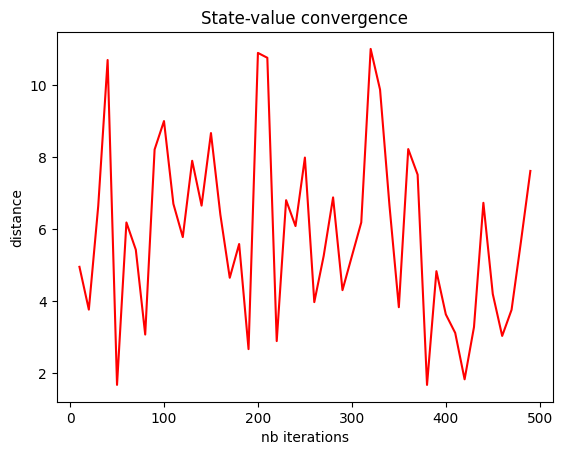

In [280]:
import matplotlib.pyplot as plt

plt.plot(nbs_iters,differences,color='red')
plt.ylabel("distance")
plt.xlabel("nb iterations")
plt.title("State-value convergence")

In [281]:
print('The optimal solution is: ',max(v))
print('The optimal policy is: ',policy_var_speed.policy)

The optimal solution is:  1.4073054991559033
The optimal policy is:  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 

##### 4. (*) In addition to the above, assume that the wind has some momentum: with 90% chances, the change in the orientation of the wind will be the same as the one during the last time step. Redo question 1 and 2 above and comment.

Since the wind orientation at time ti, is now conditioned by the previous orientation, the transitions probabilities will change as the following:

 $  P(S_{t+1} = \theta+1 | s_t = \theta,a_t = 0, wo_t=1)=0.9*1/3\\
    P(S_{t+1} = \theta+1 | s_t = \theta,a_t = 0, wo_t=0)=0.1*1/3\\
    P(S_{t+1} = \theta | s_t = \theta,a_t = 1,wo_t=1)=0.9*1/3\\
    P(S_{t+1} = \theta | s_t = \theta,a_t = 1,wo_t=0)=0.1*1/3\\
    P(S_{t+1} = \theta-1 | s_t = \theta,a_t = 2,wo_t=1)=0.9*1/3\\
    P(S_{t+1} = \theta-1 | s_t = \theta,a_t = 2,wo_t=0)=0.1*1/3\\$

In [283]:
def trans_probs_conditioned():
    probs = {}
    wind_orientation=[0,1]
    for s in STATE_SPACE :
        for a in ACTION_SPACE:
            for w in wind_orientation:
                probs[(s,a,w)] = [ 0 for i in range(len(STATE_SPACE))]
                if a == 0 and w==0: #turn left == wind turbine heading minus one
                    probs[(s,a,w)][STATE_SPACE.index((s+1)%180)] = 0.1*1/3
                elif a == 0 and w==1:
                    probs[(s,a,w)][STATE_SPACE.index((s+1)%180)] = 0.9*1/3
                elif a == 1 and w==0: #stay still
                    probs[(s,a,w)][STATE_SPACE.index(s)] = 0.1*1/3
                elif a==1 and w==1:
                    probs[(s,a,w)][STATE_SPACE.index(s)] = 0.9*1/3
                if a == 2 and w==0: #turn right == wind turbine heading plus one
                    probs[(s,a,w)][STATE_SPACE.index((s-1)%180)] = 0.1*1/3
                if a == 2 and w==1: #turn right == wind turbine heading plus one
                    probs[(s,a,w)][STATE_SPACE.index((s-1)%180)] = 0.9*1/3  

    return probs

In [284]:
class MomentumPolicy(OptimalPolicy):
    def __init__(self, rewards, probs, speed,gamma=0.8):
        super().__init__(rewards, probs, gamma)
        self.speed=speed
        self.wind_orientation=[0,1]

    def optimal_sol(self, nb_iter):
        b=0.08
        epsilon=1e-400
        V = [0 for i in range(len(STATE_SPACE))] # initialize V(s)     
        
        for i in range(nb_iter):
            delta = 0  # initialize max difference
            index=0
            V_new=V
            for s in STATE_SPACE: # compute state value
                max_value = 0
                self.speed = max(0,min(1.1,self.speed+b*np.random.uniform(-1,1))) #calculate the new wind speed
                for a in ACTION_SPACE:
                    for w in self.wind_orientation:
                        if a==0:
                            self.rewards[(s,a)]= f(self.speed)*np.cos(s*np.pi/180)-a # update the new rewards
                            val = self.rewards[(s,a)] 
                            S_next=STATE_SPACE.index((s+1)%180)
                            val += self.gamma*self.probs[(s,a,w)][S_next]*V[S_next]# add discounted downstream values
                        elif a==1:
                            self.rewards[(s,a)]= f(self.speed)*np.cos(s*np.pi/180)# update the new rewards
                            val = self.rewards[(s,a)] 
                            val += self.gamma*self.probs[(s,a,w)][index]*V[index]# add discounted downstream values
                        elif a==2:
                            self.rewards[(s,a)]= f(self.speed)*np.cos(s*np.pi/180)-a # update the new rewards
                            val = self.rewards[(s,a)] 
                            S_next=STATE_SPACE.index((s-1)%180)
                            val += self.gamma*self.probs[(s,a,w)][S_next]*V[S_next]# add discounted downstream values
                            
                    # store best value
                    max_value = max(max_value, val)

                    # update best policy
                    if V[index] < val:
                        self.policy[index]=a  # store action with highest value

                V_new[index]=max_value  # update value with highest value
                # update maximum difference
                delta = max(delta, abs(V[index] - V_new[index]))
                index+=1

            # Update value functions
            V = V_new

            # If diff smaller than threshold delta for all states, algorithm terminates
            if delta < epsilon:
                break
        return V

In [287]:
initial_speed=0.5
V_max=2
policy_momentum=MomentumPolicy(rewards=rewards(initial_speed),probs=trans_probs_conditioned(),speed=initial_speed,gamma=0.98)

In [288]:
nbs_iters = list(range(10,110,10))
differences = []
v_tmp = 0

for i in nbs_iters:
  v = policy_momentum.optimal_sol(i)
  diff = np.linalg.norm(np.asarray(v)-np.asarray(v_tmp))
  v_tmp = v.copy()
  differences.append(diff)

In order to check the convergence of the value iteration algorithm, we plot the distances between the value-state arrays of all iterations.

Text(0.5, 1.0, 'State-value convergence')

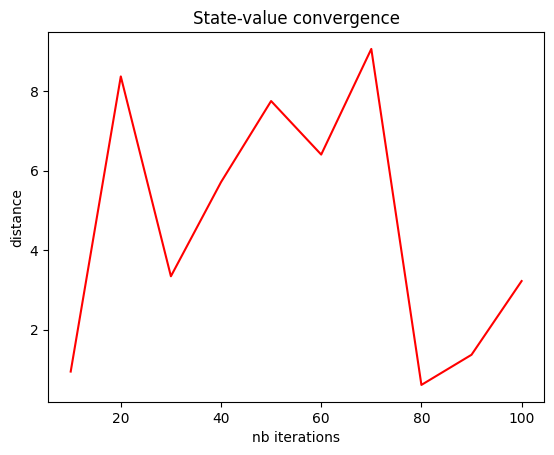

In [289]:
import matplotlib.pyplot as plt

plt.plot(nbs_iters,differences,color='red')
plt.ylabel("distance")
plt.xlabel("nb iterations")
plt.title("State-value convergence")

In [290]:
print('The optimal solution is: ',max(v))
print('The optimal policy is: ',policy_momentum.policy)

The optimal solution is:  0.7366559873917403
The optimal policy is:  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 